In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import methylcheck

## Evaluation of the workflows  
The performance of the python and federated implmentation of the workflow provided by the x group at Exeter university are compared to the original r-version of this workflow.  
Additionally the performance of the federated workflow is tested in several cases of sample size and class label imbalance.

In [47]:
GSE66351_pheno = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE66351\\Reduced_Pheno_Info.csv", index_col=0)
GSE105109_pheno = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE105109\\GSE105109_Reduced_Pheno_Info.csv", index_col=0)
GSE134379_pheno = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE134379\\Reduced_Pheno_Info.csv", index_col=0)
# make sure all the phenotype files used the same codes for the diagnosis
GSE105109_pheno.loc[GSE105109_pheno["Diagnosis"] == " Control", "Diagnosis"] = " CTRL"
GSE105109_pheno.loc[GSE105109_pheno["Diagnosis"] == " Alzheimer's disease", "Diagnosis"] = " AD"

GSE134379_pheno.loc[GSE134379_pheno["Diagnosis"] == " ND", "Diagnosis"] = " CTRL"
GSE134379_pheno.loc[GSE134379_pheno["Diagnosis"] == " AD", "Diagnosis"] = " AD"

# recode the sex column so in all datasets "gender: F" is females and "gender: M" is males
# only GSE66351 needs to be recoded that way

GSE66351_pheno.loc[GSE66351_pheno["Sex"] == " F", "Sex"] = " F"
GSE66351_pheno.loc[GSE66351_pheno["Sex"] == " M", "Sex"] = " M"

In [2]:
# read in the results from the different implementations
original_r_GSE66351_E = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE66351\\EWAS\\EWAS_GSE66351\\Small_Results_dataset.csv", index_col=0)
small_tets_r = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Fed_test\\central_r_test_out.csv", index_col=0)

#original_r_GSE105109_E = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE105109\\EWAS\\Results_small_dataset.csv", index_col=0)

#original_r_GSE134379_E = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE134379\\EWAS\\Results_small_dataset.csv", index_col=0)

#original_r_combined = None

In [3]:
python_central_GSE66351_E = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\QC_Python\\GSE66351results_diagnosis_regression_python.csv", index_col=0)
python_central_GSE105109 = None
python_central_GSE134379 = None
python_combined = None


In [6]:
federated = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_Fed\\even_splits_EWAS_results.csv", index_col=0)


In [3]:
federated_mild_imbalance = pd.read_csv("E:\Msc Systems Biology\MSB5000_Master_Thesis\Practical work\Data\GSE66351_Fed\mild_splits_EWAS_results.csv", index_col=0)
federated_strong_imbalance = pd.read_csv("E:\Msc Systems Biology\MSB5000_Master_Thesis\Practical work\Data\GSE66351_Fed\strong_splits_EWAS_results.csv", index_col=0)
small_test_federated = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Fed_test\\fed_limma_even_splits.csv", index_col=0)

In [5]:
def calculate_GroudTruth(R_EWAS_results, diff_meth_thresh = 0.05):
    #control_probe_means = Normalised_betas.loc[:, phenotype.index[phenotype["Diagnosis"] == " CTRL"]].mean(axis=1)
    #AD_probe_means = Normalised_betas.loc[:, phenotype.index[phenotype["Diagnosis"] != " CTRL"]].mean(axis=1)
    probe_difference = pd.Series.abs(R_EWAS_results.loc[:,"LogFC"])
    DM_probes = probe_difference[probe_difference >= diff_meth_thresh]
    not_DM_probes = probe_difference[probe_difference < diff_meth_thresh]

    # selecting the significant probes from the EWAS results
    EWAS_sig = R_EWAS_results.loc[R_EWAS_results["adj.P.Val"] <= 0.05, :]
    EWAS_notsig = R_EWAS_results.loc[R_EWAS_results["adj.P.Val"] > 0.05, :]

    # true positives - EWAS significant and differentially methylated
    true_positive = set(DM_probes.index.values).intersection(set(EWAS_sig.index.values))
    # true negatives - EWAS not significant and not differentially methylated
    true_negative = set(not_DM_probes.index.values).intersection(set(EWAS_notsig.index.values))
    # false positives - EWAS significant and not differentially methylated
    false_positve = set(not_DM_probes.index.values).intersection(set(EWAS_sig.index.values))
    # false negatives = EWAS not significant and differentially methylated
    false_negative = set(DM_probes.index.values).intersection(set(EWAS_notsig.index.values))

    return {"TP":true_positive, "TN":true_negative, "FP":false_positve, "FN":false_negative}

    

In [ ]:
def calculate_EWAS_metrics_p(EWAS_results, ground_truth, diff_meth_thresh = 0.05):
    #control_probe_means = Normalised_betas.loc[:, phenotype.index[phenotype["Diagnosis"] == " CTRL"]].mean(axis=1)
    #AD_probe_means = Normalised_betas.loc[:, phenotype.index[phenotype["Diagnosis"] != " CTRL"]].mean(axis=1)
    
    probe_difference = pd.Series.abs(EWAS_results.loc[:,"LogFC"])
    DM_probes = probe_difference[probe_difference >= diff_meth_thresh]
    not_DM_probes = probe_difference[probe_difference < diff_meth_thresh]

    # selecting the significant probes from the EWAS results
    
    EWAS_sig = EWAS_results.loc[EWAS_results["adj.P.Val"] <= 0.05, :]
    EWAS_notsig = EWAS_results.loc[EWAS_results["adj.P.Val"] > 0.05, :]

    # true positives - EWAS significant and differentially methylated in python/fed and in original R
    true_positive = len(set(set(DM_probes.index.values).intersection(set(EWAS_sig.index.values))).intersection(ground_truth["TP"]))
    # true negatives - EWAS not significant and not differentially methylated in python/fed and in original R
    true_negative = len(set(set(not_DM_probes.index.values).intersection(set(EWAS_notsig.index.values))).intersection(ground_truth["TN"]))
    # false positives - EWAS significant and not differentially methylated in python/fed and in original R
    false_positve = len(set(set(not_DM_probes.index.values).intersection(set(EWAS_sig.index.values))).intersection(ground_truth["FP"]))
    # false negatives = EWAS not significant and differentially methylated in python/fed and in original R
    false_negative = len(set(set(DM_probes.index.values).intersection(set(EWAS_notsig.index.values))).intersection(ground_truth["FN"]))

    Acc = (true_positive + true_negative)/(true_positive+true_negative+false_positve+false_negative)
    if (true_positive+false_positve) > 0:
        Pre = true_positive/(true_positive+false_positve)
    else:
        Pre = 0
    if (true_positive+false_negative) > 0:
        Rec = true_positive/(true_positive + false_negative)
    else:
        Rec = 0
    if Pre and Rec:
        F1 = 2*(Rec*Pre)/(Rec + Pre)
    else:
        F1 = 0

    return {"TP":true_positive, "TN":true_negative, "FP":false_positve, "FN":false_negative, "Accuracy":Acc, "Precision":Pre, "Recall":Rec, "F1":F1}


In [4]:
def groundTruthNew(R_EWAS_results, diff_meth_thresh = 0.05):
    probe_difference = pd.Series.abs(R_EWAS_results.loc[:,"logFC"])
    DM_probes = probe_difference[probe_difference >= diff_meth_thresh].index.values
    DM_probes = set(DM_probes).intersection(set(R_EWAS_results.loc[R_EWAS_results["adj.P.Val"] <= 0.05, :].index.values))
    notDM_probes = set(R_EWAS_results.index.values).difference(DM_probes)
    return {"DM":DM_probes, "Not DM":notDM_probes}

In [5]:
def EWAS_metrics_p(EWAS_results, ground_truth, diff_meth_thresh = 0.05,  multiIndex = False):
    #control_probe_means = Normalised_betas.loc[:, phenotype.index[phenotype["Diagnosis"] == " CTRL"]].mean(axis=1)
    #AD_probe_means = Normalised_betas.loc[:, phenotype.index[phenotype["Diagnosis"] != " CTRL"]].mean(axis=1)
    
    
    probe_difference = pd.Series.abs(EWAS_results.loc[:,"logFC"])
    EWAS_sig = EWAS_results.loc[EWAS_results["adj.P.Val"] <= 0.05, :].index
        
    
    good_probes = probe_difference[probe_difference >= diff_meth_thresh].index
    good_probes = set(good_probes).intersection(set(EWAS_sig))
    not_good = set(EWAS_results.index.values).difference(good_probes)

    
    # true positives - EWAS significant and differentially methylated in python/fed and in original R
    true_positive = len(ground_truth["DM"].intersection(good_probes))
    # true negatives - EWAS not significant and not differentially methylated in python/fed and in original R
    true_negative = len(ground_truth["Not DM"].intersection(not_good))
    # false positives - EWAS significant and not differentially methylated in python/fed and in original R
    false_positve = len(ground_truth["Not DM"].intersection(good_probes))
    # false negatives = EWAS not significant and differentially methylated in python/fed and in original R
    false_negative = len(ground_truth["DM"].intersection(not_good))

    Acc = (true_positive + true_negative)/(true_positive+true_negative+false_positve+false_negative)
    if (true_positive+false_positve) > 0:
        Pre = true_positive/(true_positive+false_positve)
    else:
        Pre = 0
    if (true_positive+false_negative) > 0:
        Rec = true_positive/(true_positive + false_negative)
    else:
        Rec = 0
    if Pre and Rec:
        F1 = 2*(Rec*Pre)/(Rec + Pre)
    else:
        F1 = 0

    return {"TP":true_positive, "TN":true_negative, "FP":false_positve, "FN":false_negative, "Accuracy":Acc, "Precision":Pre, "Recall":Rec, "F1":F1}


In [15]:
GSE66351_groundTruth = groundTruthNew(original_r_GSE66351_E)

In [6]:
# loop through different methylation cut-offs to compare perfomance of R and fed on test data
thresholds = {"0.01":0.01, "0.05":0.05, "0.1":0.1, "0.15":0.15, "0.2":0.20}
inner = {}
for i in thresholds:
    groundTruth = groundTruthNew(small_tets_r, diff_meth_thresh=thresholds[i])
    metrics = EWAS_metrics_p(small_test_federated, diff_meth_thresh=thresholds[i], ground_truth=groundTruth, multiIndex=True)
    inner[i] = metrics
results = pd.DataFrame.from_dict(inner).T
with pd.ExcelWriter("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\ThesisTable.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    results.to_excel(writer, sheet_name =  "TestData_EWASMetrics")

In [23]:
# loop through different methylation cut-offs to compare perfomance of R and fed
thresholds = {"0.01":0.01, "0.05":0.05, "0.1":0.1, "0.15":0.15, "0.2":0.20}
datasets = {"No Inbalance":federated, "Mild Inbalance":federated_mild_imbalance, "Strong Inbalance":federated_strong_imbalance}
results = {}
#thesis_tables = pd.ExcelWriter("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\ThesisTable.xlsx", mode="a", engine="openpyxl")
for data in datasets:
    inner = {}
    for i in thresholds:
        groundTruth = groundTruthNew(original_r_GSE66351_E, diff_meth_thresh=thresholds[i])
        metrics = EWAS_metrics_p(datasets[data], diff_meth_thresh=thresholds[i], ground_truth=groundTruth, multiIndex=True)
        inner[i] = metrics
    results[data] = pd.DataFrame.from_dict(inner).T
    # save the metric tables to excel
    with pd.ExcelWriter("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\ThesisTable.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        results[data].to_excel(writer, sheet_name = (data + "EWASMetrics"))

    

In [11]:
diff_ids_even = set(original_r_GSE66351_E.loc[original_r_GSE66351_E["adj.P.Val"]<=0.05, :].index.values).difference(set(federated.loc[federated["adj.P.Val"]<=0.05, :].index.values))
diff_ids_mild = set(original_r_GSE66351_E.loc[original_r_GSE66351_E["adj.P.Val"]<=0.05, :].index.values).difference(set(federated_mild_imbalance.loc[federated_mild_imbalance["adj.P.Val"]<=0.05, :].index.values))
diff_ids_strong = set(original_r_GSE66351_E.loc[original_r_GSE66351_E["adj.P.Val"]<=0.05, :].index.values).difference(set(federated_strong_imbalance.loc[federated_strong_imbalance["adj.P.Val"]<=0.05, :].index.values))

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
#r and fed beta deviation desity distribution plot

Text(0.5, 1.0, 'Strong imbalance - Federated')

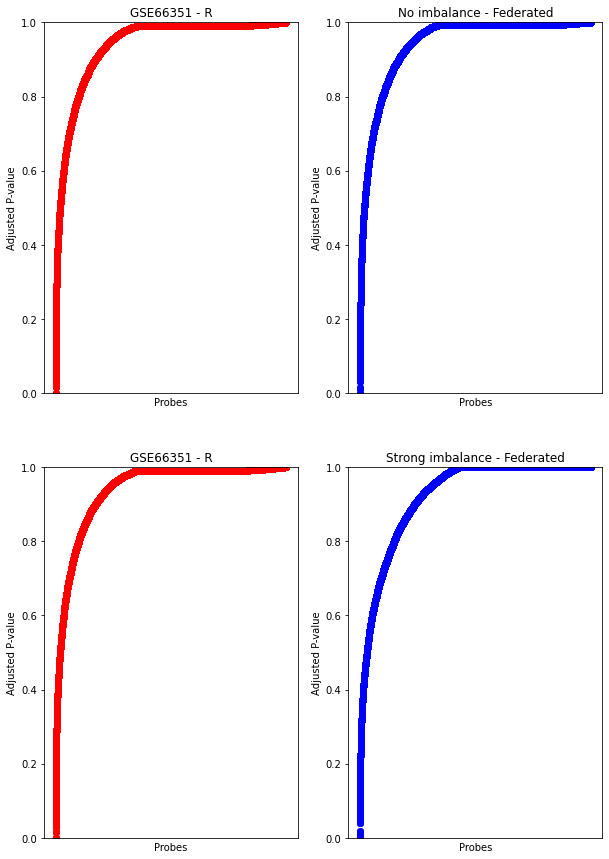

In [8]:
#scatterplot p-values distributions r and fed python in the different scenarios
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols = 2, nrows=2, figsize=(10,15))
# no imbalance - r
ax1.scatter(x=original_r_GSE66351_E.index.values, y = original_r_GSE66351_E.loc[:, "adj.P.Val"], c="r")
#ax1.hlines(y=0.05, xmin=0, xmax=int(len(federated.index.values)))
ax1.set_ylim((0.00,1.00))
ax1.set_ylabel("Adjusted P-value")
ax1.set_xlabel("Probes")
ax1.set_xticks([])
ax1.set_title("GSE66351 - R")
# no imbalance - fed
ax2.scatter(x=federated.index.values, y = federated.loc[:, "adj.P.Val"], c="b")
#ax2.hlines(y=0.05, xmin=0, xmax=int(len(federated_mild_imbalance.index.values)))
ax2.set_ylim((0.00,1.00))
ax2.set_ylabel("Adjusted P-value")
ax2.set_xlabel("Probes")
ax2.set_xticks([])
ax2.set_title("No imbalance - Federated")
#strong - r
ax3.scatter(x=original_r_GSE66351_E.index.values, y = original_r_GSE66351_E.loc[:, "adj.P.Val"], c="r")
#ax3.hlines(y=0.05, xmin=0, xmax=int(len(federated_mild_imbalance.index.values)))
ax3.set_ylim((0.00,1.00))
ax3.set_ylabel("Adjusted P-value")
ax3.set_xlabel("Probes")
ax3.set_xticks([])
ax3.set_title("GSE66351 - R")
# strong - fed
ax4.scatter(x=federated_strong_imbalance.index.values, y = federated_strong_imbalance.loc[:, "adj.P.Val"], c="b")
#ax4.hlines(y=0.05, xmin=0, xmax=int(len(federated_mild_imbalance.index.values)))
ax4.set_ylim((0.00,1.00))
ax4.set_ylabel("Adjusted P-value")
ax4.set_xlabel("Probes")
ax4.set_xticks([])
ax4.set_title("Strong imbalance - Federated")





In [9]:
fig.savefig("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Evaluations\\PValue_Dist_NoStrongImb.jpeg")

Text(0.5, 1.0, 'Strong imbalance - Federated')

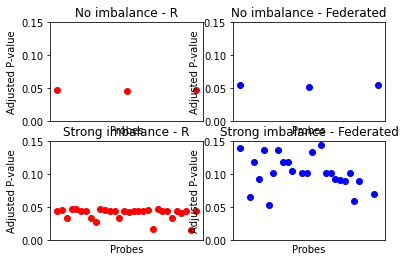

In [15]:
#scatterplot with p-values for the diff ids in R and fed-python
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
# no imbalance - r
ax1.scatter(x=list(diff_ids_even), y = original_r_GSE66351_E.loc[diff_ids_even, "adj.P.Val"], c="r")
#ax1.hlines(y=0.05, xmin=0, xmax=int(len(federated.index.values)))
ax1.set_ylim((0.00,0.15))
ax1.set_ylabel("Adjusted P-value")
ax1.set_xlabel("Probes")
ax1.set_xticks([])
ax1.set_title("No imbalance - R")
# no imbalance - fed
ax2.scatter(x=list(diff_ids_even), y = federated.loc[diff_ids_even, "adj.P.Val"], c="b")
#ax2.hlines(y=0.05, xmin=0, xmax=int(len(federated_mild_imbalance.index.values)))
ax2.set_ylim((0.00,0.15))
ax2.set_ylabel("Adjusted P-value")
ax2.set_xlabel("Probes")
ax2.set_xticks([])
ax2.set_title("No imbalance - Federated")
#strong - r
ax3.scatter(x=list(diff_ids_strong), y = original_r_GSE66351_E.loc[diff_ids_strong, "adj.P.Val"], c="r")
#ax3.hlines(y=0.05, xmin=0, xmax=int(len(federated_mild_imbalance.index.values)))
ax3.set_ylim((0.00,0.15))
ax3.set_ylabel("Adjusted P-value")
ax3.set_xlabel("Probes")
ax3.set_xticks([])
ax3.set_title("Strong imbalance - R")
# strong - fed
ax4.scatter(x=list(diff_ids_strong), y = federated_strong_imbalance.loc[diff_ids_strong, "adj.P.Val"], c="b")
#ax4.hlines(y=0.05, xmin=0, xmax=int(len(federated_mild_imbalance.index.values)))
ax4.set_ylim((0.00,0.15))
ax4.set_ylabel("Adjusted P-value")
ax4.set_xlabel("Probes")
ax4.set_xticks([])
ax4.set_title("Strong imbalance - Federated")

In [16]:
fig.savefig("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Evaluations\\PValueDiff_Dist_NoStrongImb.jpeg")

In [8]:
original_r_GSE66351_E.loc[diff_ids_even, :]

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
cg07594247,0.048671,0.028727,0.068615,0.760135,4.817768,0.000003,0.045525,2.862706
cg24577417,0.012165,0.007139,0.017191,0.851773,4.778236,0.000004,0.047249,2.695131
cg06692974,0.061565,0.036143,0.086987,0.856061,4.781000,0.000004,0.047249,2.706812


In [9]:
federated.loc[diff_ids_even, :]

,t,lods,logFC,CI.L,CI.R,adj.P.Val,P.Value
cg07594247,4.755444,2.593621,0.048192,0.028183,0.068200,0.051232,0.000004
cg24577417,4.722451,2.455268,0.012085,0.007032,0.017137,0.054476,0.000005
cg06692974,4.719515,2.442989,0.060694,0.035303,0.086085,0.054476,0.000005


In [28]:
set(federated["adj.P.Val"]<=0.05)

{False, True}

In [55]:
GSE66351_metrics_p = EWAS_metrics_p(python_central_GSE66351_E, diff_meth_thresh=0.05, ground_truth = GSE66351_groundTruth, multiIndex=False)
federated_metrics = EWAS_metrics_p(federated, diff_meth_thresh=0.05, ground_truth = GSE66351_groundTruth, multiIndex=True)
# combine the metrics results into one dataframe
performance_results = pd.DataFrame.from_dict([GSE66351_metrics_p, federated_metrics])
performance_results.index = ["GSE66351 Pyhton central", "GSE66351 Federated"]
#performance_results.to_excel("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\ThesisTables.xlsx")

performance_results

,TP,TN,FP,FN,Accuracy,Precision,Recall,F1
GSE66351 Pyhton central,2,450789,38,8,0.999898,0.05,0.2,0.08
GSE66351 Federated,0,450827,0,10,0.999978,0.00,0.0,0.00


In [41]:
GSE66351_groundTruth["DM"].intersection(set(python_central_GSE66351_E.loc[python_central_GSE66351_E.loc[:,"Corrected P-value"] <= 0.05,:])) 

set()

In [51]:
len(set(python_central_GSE66351_E.loc[python_central_GSE66351_E.loc[:,"Corrected P-value"] <= 0.05].index))

40

In [43]:
len(GSE66351_groundTruth["DM"])

10